In [1]:
import sys, os
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns 

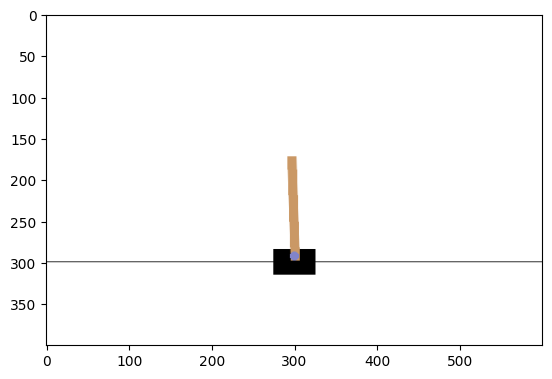

In [2]:
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    os.environ['DISPLAY'] = ':1'

env = gym.make("CartPole-v0")
if hasattr(env, '_max_episode_steps'):
    env = env.env
env.reset()

n_actions = env.action_space.n
state_dim = env.observation_space.shape
plt.imshow(env.render("rgb_array"))

In [3]:
#модель
model = nn.Sequential(
    nn.Linear(state_dim[0], 128),
    nn.ReLU(),
    nn.Linear(128, n_actions)
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
def predict_probs(states):
    """
    Прогнозирует вероятности действий при заданных состояниях.
    :param states: numpy массив формы [batch, state_shape]
    :returns: numpy массив формы [batch, n_actions]
    """
    return model(torch.as_tensor(np.array(states))).softmax(dim=-1).data.numpy()

Игра с моделью

In [5]:
def generate_session(env, t_max=1000):
    """
    Сыграйте полную сессию с агентом REINFORCE.
    Возвращает последовательности состояний, действий и наград.
    """
    #массивы для записи сессии
    states, actions, rewards = [], [], []
    s = env.reset()

    for t in range(t_max):
        #прогнозируем вероятности действий
        action_probs = predict_probs([s])
        #пример действия с заданной вероятностью
        a = np.random.choice(n_actions, p=action_probs[0])

        new_s, r, done, info = env.step(a)
        #записываем историю сессий, для последующего обучения
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break

    return states, actions, rewards

In [6]:
#проверка
states, actions, rewards = generate_session(env)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Расчет кумулятивных вознаграждений

In [7]:
# Рассчитывает кумулятивные вознаграждения для каждого шага с учетом дисконтирования
def get_cumulative_rewards(rewards, gamma=0.99):
    cumulative_rewards = np.zeros_like(rewards, dtype=float)
    cumulative_rewards[-1] = rewards[-1]

    for t in range(len(rewards)-2, -1, -1): # Идем по вознаграждениям в обратном порядке (с конца)
        cumulative_rewards[t] = rewards[t] + gamma * cumulative_rewards[t+1]

    return cumulative_rewards

In [8]:
#тесты
get_cumulative_rewards(rewards)
assert len(get_cumulative_rewards(list(range(100)))) == 100
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9),
    [1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, -2, 3, -4, 0], gamma=0.5),
    [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 2, 3, 4, 0], gamma=0),
    [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


Функция потерь и обновления

In [9]:
# Функция потерь и обновлений
def compute_loss(log_policy_for_actions, cumulative_rewards, policy, gamma=0.99):
    J = torch.mean(log_policy_for_actions * cumulative_rewards) #рассчитываем ожидаемую сумму вознаграждений для каждого действия
    entropy = -torch.mean(torch.sum(policy * torch.log(policy), dim=1))#вычисляем энтропию стратегии для регуляризации (чтобы избежать слишком детерминированных действий)
    loss = -(J + 0.1 * entropy) # итоговые потери
    return loss

In [10]:
# Инициализация оптимизатора
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# Функция обучения на одной сессии
def train_on_session(states, actions, rewards, t_max=1000):
    """в полном объеме обучает агента градиенту политики"""
    cumulative_rewards = get_cumulative_rewards(rewards)

    # Преобразуем списки состояний, действий и вознаграждений в тензоры PyTorch
    states_tensor = torch.tensor(np.array(states), dtype=torch.float32)
    actions_tensor = torch.tensor(actions, dtype=torch.long)
    cumulative_rewards_tensor = torch.tensor(cumulative_rewards, dtype=torch.float32)

    logits = model(states_tensor)# Получаем логииты для каждого состояния
    log_policy = torch.nn.functional.log_softmax(logits, dim=-1)# Применяем log-softmax для получения логарифмов вероятностей

    # Используем прямое индексирование для извлечения log_policy для выбранных действий
    indices = torch.arange(log_policy.size(0), dtype=torch.long)
    log_policy_for_actions = log_policy[indices, actions_tensor]
    # Вычисляем потери
    loss = compute_loss(log_policy_for_actions, cumulative_rewards_tensor, torch.softmax(log_policy, dim=-1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return sum(rewards)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# Инициализация оптимизированных параметров
model.train()

# Главный цикл обучения
for i in range(100):
    rewards = [train_on_session(*generate_session(env)) for _ in range(100)]  # создание новой сессии
    print("mean reward: %.3f" % (np.mean(rewards)))
    if np.mean(rewards) > 300:
        print("You Win!")
        break

mean reward: 27.940
mean reward: 34.860
mean reward: 46.490
mean reward: 49.980
mean reward: 95.010
mean reward: 175.700
mean reward: 144.240
mean reward: 299.390
mean reward: 391.490
You Win!
